# Is there any relationship between forest area and forest and suicides?

Required tools and libraries in this analysis:

In [11]:
import pandas as pd
import basedosdados as bd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

## Available data
### To approach this question we'll consider the following datasets:
#### 1. [Sistema de Informações sobre Mortalidade (SIM)](https://basedosdados.org/dataset/br-ms-sim?bdm_table=microdados)
Brazilian Health Ministry's report on mortality from 1996 to 2020.

We'll consider all deaths with basic cause (causa_basica, CID-10) codes: X60-X84 and Y87.0 [1] 


#### 2. [Censo Agropecuário](https://basedosdados.org/dataset/br-ibge-censo-agropecuario?bdm_table=municipio)
Brazilian Institute of Geography and Statistics' report on agriculture census from 1985 to 2017.
 
#### 3. [População brasileira](https://basedosdados.org/dataset/br_ibge_populacao?bdm_table=municipio)
Brazilian Institute of Geography and Statistics' report on estimated population from 1991 to 2021.

### 4 [Produto Interno Bruto do Brasil](https://basedosdados.org/dataset/br-ibge-pib?bdm_table=municipio)
Brazilian Institute of Geography and Statistics' report on Gross Domestic Product at current prices from 2002 to 2019.


### References:
- [1] [Mortalidade por suicídio e notificações de lesões autoprovocadas no Brasil](https://www.gov.br/saude/pt-br/centrais-de-conteudo/publicacoes/boletins/epidemiologicos/edicoes/2021/boletim_epidemiologico_svs_33_final.pdf)


## Study case: municipios, 2007 
Lets focus on the year of 2017, as it is covered by all datasets and the most recent available Censo Agropecuário.

### Data gathering

In [4]:
class Get_data:    
    def _unpack(self, l):
        return ", ".join(map(str, l))

    def _get_data(self, filename, query):
        try:
            return pd.read_csv(f'../data/{filename}.csv')
        except FileNotFoundError:
            df = bd.read_sql(query=query,
                             billing_project_id='explorando-basedosdados')
            df.to_csv(
                f'../data/{filename}.csv', index=False)
            return df

    def sim_suic_municipio(self,year):
        filename = f'sim_suic_municipio_{year}'
        columns = ('id_municipio', 'SUM(numero_obitos) as numero_obitos')
        query = f"""
                SELECT 
                    {self._unpack(columns)}
                FROM 
                    basedosdados.br_ms_sim.municipio_causa
                WHERE 
                    ano = {year}
                    AND (
                        CONTAINS_SUBSTR(causa_basica, 'X6')
                        OR CONTAINS_SUBSTR(causa_basica, 'X7')
                        OR CONTAINS_SUBSTR(causa_basica, 'X8')
                        OR causa_basica = 'Y870'
                        )
                    GROUP BY id_municipio
                """
        return self._get_data(filename, query)

    def agro_forest_municipio(self,year):
        filename = f'agro_forest_municipio_{year}'
        columns = ('id_municipio',
                   'area_total',
                   'area_mata_natural',
                   'area_mata_plantada',
                   'area_sistema_agroflorestal',
                   'area_mata')
        query = f"""
                SELECT 
                    {self._unpack(columns)}
                FROM 
                    basedosdados.br_ibge_censo_agropecuario.municipio
                WHERE
                    ano = {year}
                    """
        return self._get_data(filename, query)

    def sim_suic_pop_municipio(self,year):
        query = f"""
                WITH obitos AS 
                    (
                        SELECT 
                            id_municipio, SUM(numero_obitos) as numero_obitos 
                        FROM 
                            basedosdados.br_ms_sim.municipio_causa
                        WHERE 
                            ano = 2017 
                        AND (
                            CONTAINS_SUBSTR(causa_basica, 'X6')
                            OR CONTAINS_SUBSTR(causa_basica, 'X7')
                            OR CONTAINS_SUBSTR(causa_basica, 'X8')
                            OR causa_basica = 'Y870'
                            )
                        GROUP BY 
                            id_municipio

                    ), 
                    populacao AS 
                        (
                            SELECT 
                                id_municipio, populacao 
                            FROM 
                                `basedosdados.br_ibge_populacao.municipio` 
                            WHERE 
                                ano = {year} 

                        )
                SELECT 
                obitos.id_municipio, obitos.numero_obitos, populacao.populacao 
                FROM 
                obitos JOIN populacao ON obitos.id_municipio = populacao.id_municipio
                """
        return self._get_data(f'sim_sui_pop_municipio_{year}',query)
        

    def pib_pc_municipio(self,year):
        query = f"""
                    SELECT 
                        pib.id_municipio,
                        (pib.PIB / pop.populacao) as pib_pc
                    FROM 
                        basedosdados.br_ibge_pib.municipio as pib
                    INNER JOIN 
                        basedosdados.br_ibge_populacao.municipio as pop
                    ON 
                        pib.id_municipio = pop.id_municipio 
                        AND 
                            pib.ano = pop.ano
                    WHERE 
                        pib.ano = {year}
                """

        df = self._get_data(f'pib_pc_{year}',query)
        df['id_municipio'] = df['id_municipio'].astype('int64')
        return df
    def get_dfs(self, year):
        dfs = [self.agro_forest_municipio(year),
                self.sim_suic_pop_municipio(year),
                self.pib_pc_municipio(year)]
        return dfs
get_data = Get_data()
year = 2017
agro_forest_2017, sim_sui_pop_2017, pib_pc_2017 = get_data.get_dfs(year)

In [111]:
sim_sui_pop_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   id_municipio   3144 non-null   int64
 1   numero_obitos  3144 non-null   int64
 2   populacao      3144 non-null   int64
dtypes: int64(3)
memory usage: 73.8 KB


In [110]:
agro_forest_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5563 entries, 0 to 5562
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_municipio                5563 non-null   int64  
 1   area_total                  5563 non-null   float64
 2   area_mata_natural           5563 non-null   float64
 3   area_mata_plantada          5563 non-null   float64
 4   area_sistema_agroflorestal  5563 non-null   float64
 5   area_mata                   5563 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 260.9 KB


In [139]:
pib_pc_2017.head() 

,id_municipio,pib_pc
0,1100015,19081.429886
1,1100023,21313.618510
2,1100031,22189.904242
3,1100049,23532.162710
4,1100056,24492.328538


## Results

In [14]:
import functools as ft
import numpy as np

def normalize(x):
    mean_x = x.mean()
    std_x = x.std()
    return ((x - mean_x) / std_x)


def merge_dfs(dfs):
    df = ft.reduce(lambda left, right: pd.merge(left, right, on='id_municipio'), dfs)

    df['taxa_obito_10k'] = df['numero_obitos'] / df['populacao'] * 10_000
    df['taxa_mata'] = df['area_mata'] / df['area_total']
    df['pib_pc_norm'] = normalize(df['pib_pc'])
    df['pib_pc_log2'] = np.log2(df['pib_pc'])
    return df

# Scatter plotting
def plot(df, x_df, y_df, c_df=None, 
        xlabel=None,
        ylabel=None,
        filename=None):
            fig = plt.figure(figsize=(20, 10))
            ax = plt.subplot()
            base_colors = [
                "#E66E52",
                "#F3A061",
                "#E8C36A",
                "#87D397",
                "#22926E",
                "#184C5F",
            ]
            base_cmap = ListedColormap(base_colors)

            df.plot.scatter(
                x=x_df,
                y=y_df,
                c=c_df,
                ax=ax,
                cmap=base_cmap,
                alpha=0.85,
            )
            
            ax.set_xlabel(xlabel, fontsize=20)
            ax.set_ylabel(ylabel, fontsize=20)
            if filename != None:
                fig.savefig(f'../data/output/{filename}',dpi=300)
            return ax
    

In [9]:
dfs_2017 = [sim_sui_pop_2017, agro_forest_2017, pib_pc_2017] 
df_2017 = merge_dfs(dfs_2017)
df_2017.describe()

,id_municipio,numero_obitos,populacao,area_total,area_mata_natural,area_mata_plantada,area_sistema_agroflorestal,area_mata,pib_pc,taxa_obito_10k,taxa_mata,pib_pc_norm,pib_pc_log2
count,3.139000e+03,3139.000000,3.139000e+03,3.139000e+03,3.139000e+03,3139.000000,3139.000000,3.139000e+03,3139.000000,3139.000000,3134.000000,3.139000e+03,3139.000000
mean,3.269440e+06,3.961453,5.821354e+04,7.532215e+04,1.944522e+04,1757.262823,2877.421153,2.120248e+04,23300.204488,1.446534,0.239828,9.828250e-16,14.152286
std,9.801315e+05,12.023537,2.889167e+05,1.659813e+05,5.625600e+04,7878.746002,8954.535850,5.804057e+04,21055.102718,1.369895,0.167547,1.000000e+00,0.975888
min,1.100015e+06,1.000000,8.120000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,3289.500094,0.113830,0.000000,-9.503969e-01,11.683653
25%,2.515954e+06,1.000000,9.031500e+03,1.346900e+04,1.776500e+03,0.000000,0.000000,2.071000e+03,10281.787211,0.568107,0.120945,-6.183022e-01,13.327803
50%,3.155207e+06,2.000000,1.911000e+04,2.894100e+04,4.676000e+03,80.000000,136.000000,5.457000e+03,18404.728795,0.999400,0.202137,-2.325078e-01,14.167789
75%,4.122552e+06,3.000000,4.069900e+04,7.013350e+04,1.422800e+04,824.500000,1542.500000,1.646500e+04,29650.221040,1.836483,0.315595,3.015904e-01,14.855755
max,5.300108e+06,432.000000,1.210692e+07,4.810916e+06,1.125556e+06,227250.000000,206666.000000,1.125574e+06,346739.343545,15.313936,0.975643,1.536156e+01,18.403492


<AxesSubplot:xlabel='Proporção de mata por área', ylabel='Incidência de suicidio'>

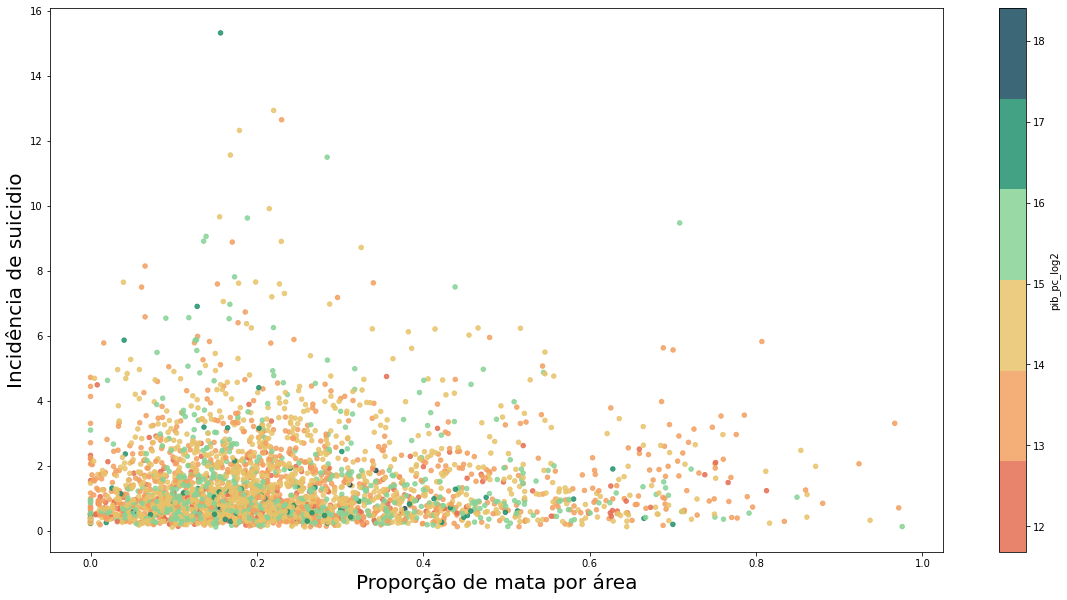

In [12]:
plot(df_2017,'taxa_mata','taxa_obito_10k','pib_pc_log2',
    xlabel='Proporção de mata por área',
    ylabel='Incidência de suicidio')

In [32]:
# Calculating Correlation

df_2017['taxa_obito_10k'].corr(df_2017['taxa_mata'],method='spearman')

0.024351890717812488

In [35]:
# Calculating Mutual Information
# source: [Mutual Information](https://www.kaggle.com/code/ryanholbrook/mutual-information)
from sklearn.feature_selection import mutual_info_regression


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(
        X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores


df = df_2017.dropna()
make_mi_scores(df.iloc[:, 2:], df.taxa_obito_10k, 'auto')


taxa_obito_10k                6.787954
populacao                     1.765434
area_total                    0.068866
area_mata_natural             0.042441
area_mata                     0.036551
area_sistema_agroflorestal    0.023435
area_mata_plantada            0.000000
taxa_mata                     0.000000
Name: MI Scores, dtype: float64

<AxesSubplot:xlabel='Proporção de mata por área', ylabel='Incidência de suicidio'>

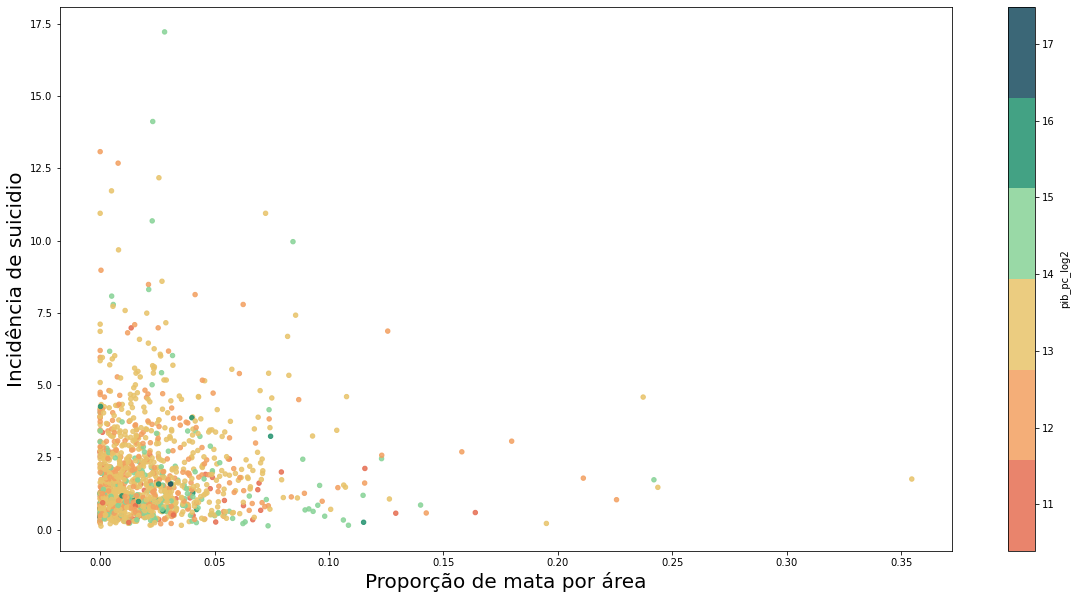

In [13]:
year = 2006
# dfs_2016 = [agro_forest_2006, sim_sui_pop_2006, pib_pc_2006] = get_data.get_dfs(year)
df_2006 = merge_dfs(get_data.get_dfs(year))

plot(df_2006,'taxa_mata','taxa_obito_10k','pib_pc_log2',
    xlabel='Proporção de mata por área',
    ylabel='Incidência de suicidio')

## Conclusions
To explore the possible relation between forest area and suicide rate we gather and combined data on mortality, agricultural census and Brazilian population. Stablished the two variables of interest: the couties' rates of forest (forest area over total area) and suicide (# suicides over population). 

We've used a scatter plot to visualize the data distribution considering suicide rate x forest rate. Complemented by correlation and mutual information scores of the variables. 

As we were expecting, it does't seem the exist a simple, strong, relation between suicides and forest area in Brazilian counties. 
At least in the year of 2017, at least within the limited scope of this brief exploration.

In fact, from the considered variables, population and total area of counties seem the be the most relavant. 

Further research considering economic and social factors from counties, such as median income, gdp per capita, occupation and education could further elucidate this complex matter.